----
# Minumum number of features for SVM classification
----

In [19]:
#import libraries
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

import pandas as pd

import standardization as sd                                #Self written, Scikit-learn do have standardScaler which does the same.
import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
#smaller dataset for feature selection
for_feature_selection = pd.read_csv("../TrainingData/neodata/fault_all_10.csv")

# Load training data
train_data = pd.read_csv("../TrainingData/neodata/fault_all_no_noise_100.csv")
test_data = pd.read_csv("../TestData/neodata/fault_all_no_noise_100.csv")
vald_data=pd.read_csv("../ValidationData/neodata/fault_all_no_noise_100.csv")

In [21]:
#Normalization / conditioning
standardizer = sd.standardization(train_data,'target')

fts = standardizer.transform(for_feature_selection)
trn = standardizer.transform(train_data)
tst = standardizer.transform(test_data)
val = standardizer.transform(vald_data)

targets = train_data['target'].unique().tolist()        # List of classes

labels_tst = test_data['target']


SVM classifier on 10 point dataset to evaluate which features to drop

In [22]:
from sklearn import svm

clf0 = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
clf0.fit(fts.drop('target',axis=1), fts['target'])


SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

Sequential feature selector to select important features

In [23]:
from sklearn.feature_selection import SequentialFeatureSelector

features = 5

bw = SequentialFeatureSelector(clf0,direction='backward',n_jobs=8,n_features_to_select=features)

In [24]:
bw.fit(fts.drop('target',axis=1), fts['target'])  #might take more than 30 seconds

SequentialFeatureSelector(direction='backward',
                          estimator=SVC(C=1000, decision_function_shape='ovo',
                                        gamma=0.01),
                          n_features_to_select=5, n_jobs=8)

Which features are dropped?

In [25]:
labels = trn.drop('target',axis=1).columns
dropped = labels[np.invert(bw.get_support())]
dropped

Index(['Pdis', 'Psuc', 'T0', 'Tsh', 'Tsup', 'CondFan', 'CprPower', 'Density',
       'Tamb'],
      dtype='object')

How the remaining dataset looks like

In [26]:
trn_reduced = trn.drop(dropped,axis=1)
tst_reduced = tst.drop(dropped,axis=1)
val_reduced = val.drop(dropped,axis=1)
trn_reduced

,Tc,Tdis,Tret,Tsuc,Tset,target
0,-1.088636,-0.365470,-0.945271,-0.989183,-1.286825,0
1,-1.088058,-0.364793,-0.945153,-0.989137,-1.286825,0
2,-1.088752,-0.365599,-0.945298,-0.989196,-1.286825,0
3,-1.088934,-0.365799,-0.945343,-0.989219,-1.286825,0
4,-1.089220,-0.366107,-0.945416,-0.989260,-1.286825,0
...,...,...,...,...,...,...
37795,3.689506,1.778357,0.420295,0.496959,1.151370,20
37796,3.689708,1.778582,0.420274,0.496936,1.151370,20
37797,3.689643,1.778511,0.420281,0.496943,1.151370,20
37798,3.690417,1.779353,0.420215,0.496869,1.151370,20


Training a full classifier on more datapoint with the features dropped

In [27]:
clf = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
clf.fit(trn_reduced.drop('target',axis=1), trn_reduced['target'])

SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

In [28]:
#predicting
predict = clf.predict(trn_reduced.drop('target',axis=1))

print(trn_reduced['target'].to_numpy())
print(predict)

[ 0  0  0 ... 20 20 20]
[ 8  8  8 ... 20 20 20]


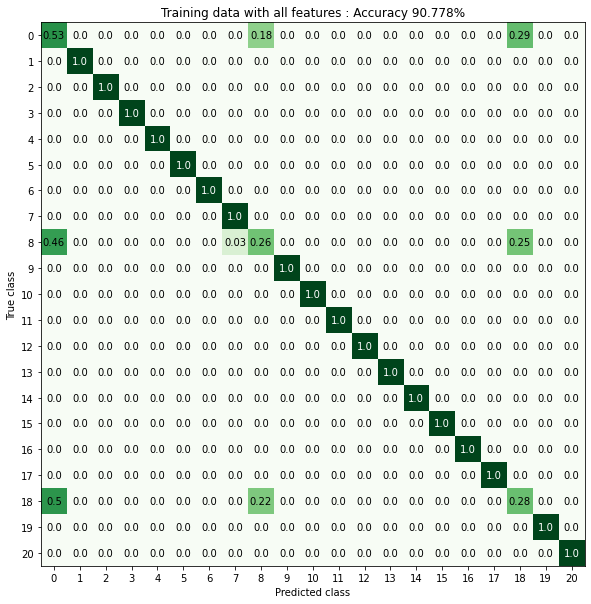

In [12]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict,trn_reduced['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'Training data with {features} features',eval_labels = False)
pass

In [13]:
#predicting
predict_val = clf.predict(val_reduced.drop('target',axis=1))

print(val_reduced['target'].to_numpy())
print(predict_val)

[ 0  0  0 ... 20 20 20]
[18 18 18 ... 20 20 20]


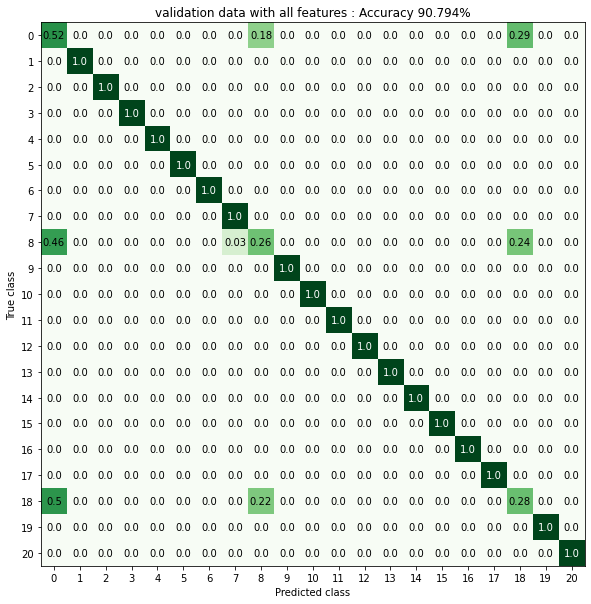

In [17]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict_val,val_reduced['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'validation data with {features} features',eval_labels = False)
pass

In [15]:
#predicting
predict_tst = clf.predict(tst_reduced.drop('target',axis=1))

print(val_reduced['target'].to_numpy())
print(predict_tst)

[ 0  0  0 ... 20 20 20]
[11 11 11 ... 20 20 20]


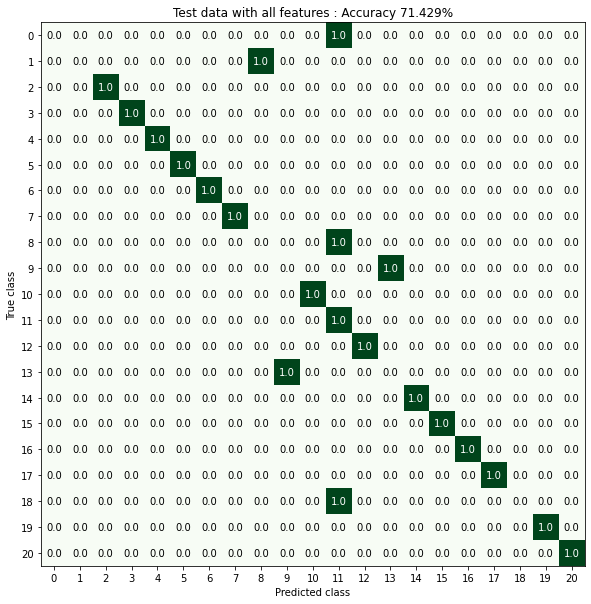

In [18]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict_tst,tst_reduced['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'Test data with {features} features',eval_labels = False, save_fig_name='PDF/SVM test with all features.pdf')
pass

# Extra:<br>
plot accuracies against the number of features (takes some time)

In [51]:
from sklearn.feature_selection import SequentialFeatureSelector

accuracies = pd.DataFrame({'n_features':[],'val':[],'tst':[]})

for i in range(2,14):
    bw = SequentialFeatureSelector(clf0,direction='backward',n_jobs=10,n_features_to_select=i)
    bw.fit(fts.drop('target',axis=1), fts['target'])
    print(i)
    labels = trn.drop('target',axis=1).columns
    dropped = labels[np.invert(bw.get_support())]

    trn_reduced = trn.drop(dropped,axis=1)
    tst_reduced = tst.drop(dropped,axis=1)
    val_reduced = val.drop(dropped,axis=1)

    clf = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
    clf.fit(trn_reduced.drop('target',axis=1), trn_reduced['target'])

    val_score = clf.score(val_reduced.drop('target',axis=1),val_reduced['target'])
    test_score = clf.score(tst_reduced.drop('target',axis=1),tst_reduced['target'])
    print(f"val:{val_score} test:{test_score}")
    accuracies = accuracies.append({'n_features':i,'val':val_score,'tst':test_score},ignore_index=True)

accuracies

2
val:0.28634920634920635 test:0.23809523809523808
3
val:0.6815608465608466 test:0.6666666666666666
4
val:0.783068783068783 test:0.7595238095238095
5
val:0.8954232804232805 test:0.9047619047619048
6
val:0.905079365079365 test:0.9047619047619048
7
val:0.9043386243386243 test:0.8571428571428571
8
val:0.9061111111111111 test:0.8571428571428571
9
val:0.9059259259259259 test:0.8571428571428571
10
val:0.9057142857142857 test:0.8571428571428571
11
val:0.905952380952381 test:0.8571428571428571
12
val:0.9073809523809524 test:0.8571428571428571
13
val:0.9061111111111111 test:0.8571428571428571


,n_features,val,tst
0,2.0,0.286349,0.238095
1,3.0,0.681561,0.666667
2,4.0,0.783069,0.759524
3,5.0,0.895423,0.904762
4,6.0,0.905079,0.904762
5,7.0,0.904339,0.857143
6,8.0,0.906111,0.857143
7,9.0,0.905926,0.857143
8,10.0,0.905714,0.857143
9,11.0,0.905952,0.857143


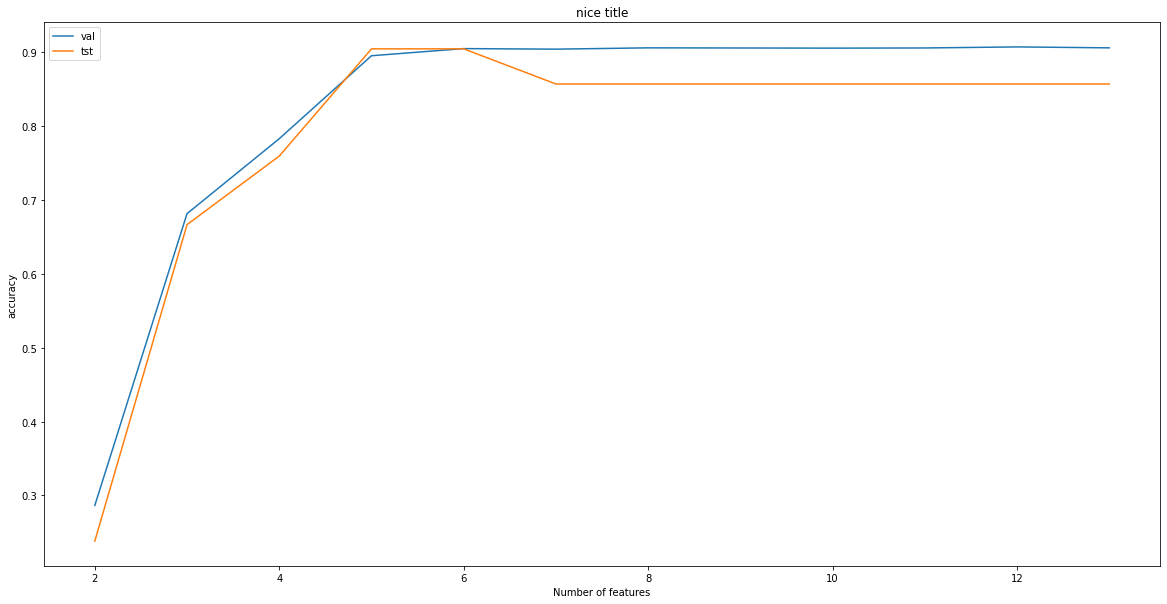

In [53]:
plt.figure(figsize=(20,10))
plt.plot(accuracies['n_features'],accuracies[['val','tst']])
plt.ylabel('accuracy')
plt.xlabel('Number of features')
plt.title('SVM classifier accuracy against the number of features used')
plt.legend(['val','tst'])

### Observation:
using 5-6 features, the svm classifier successfully classifies the faults. further increasing the features does not yield higher classification accuracy.<br>